<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

In [4]:
plt.rcParams['figure.figsize'] = (15, 15)

### Triplet Loss

In [5]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()

# ref: https://github.com/adambielski/siamese-triplet/blob/0c719f9e8f59fa386e8c59d10b2ddde9fac46276/losses.py#L24 

In [6]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)

# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [7]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [8]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

4

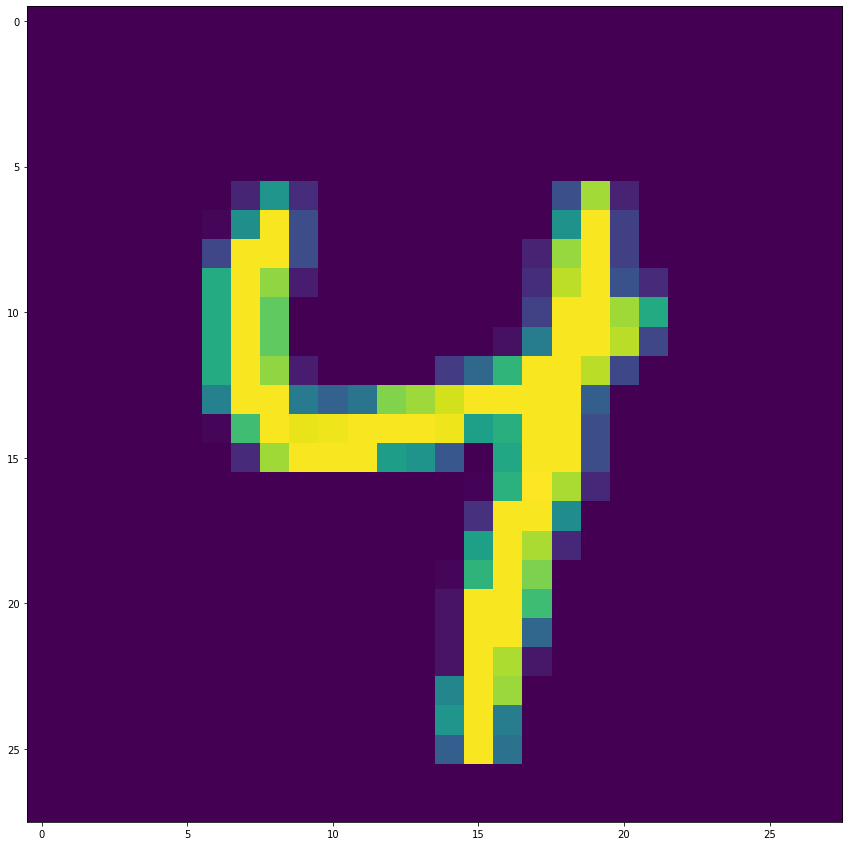

In [9]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

## Reorganizing Data

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: torch.stack((image,image,image), dim=-3)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.449, std=0.225),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

processed_data = preprocess(MNIST_train.data)

In [2]:
train_dict = {i : MNIST_train.data[MNIST.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{len(imgs)} images of Label {label}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

NameError: ignored

In [218]:
label = 8
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


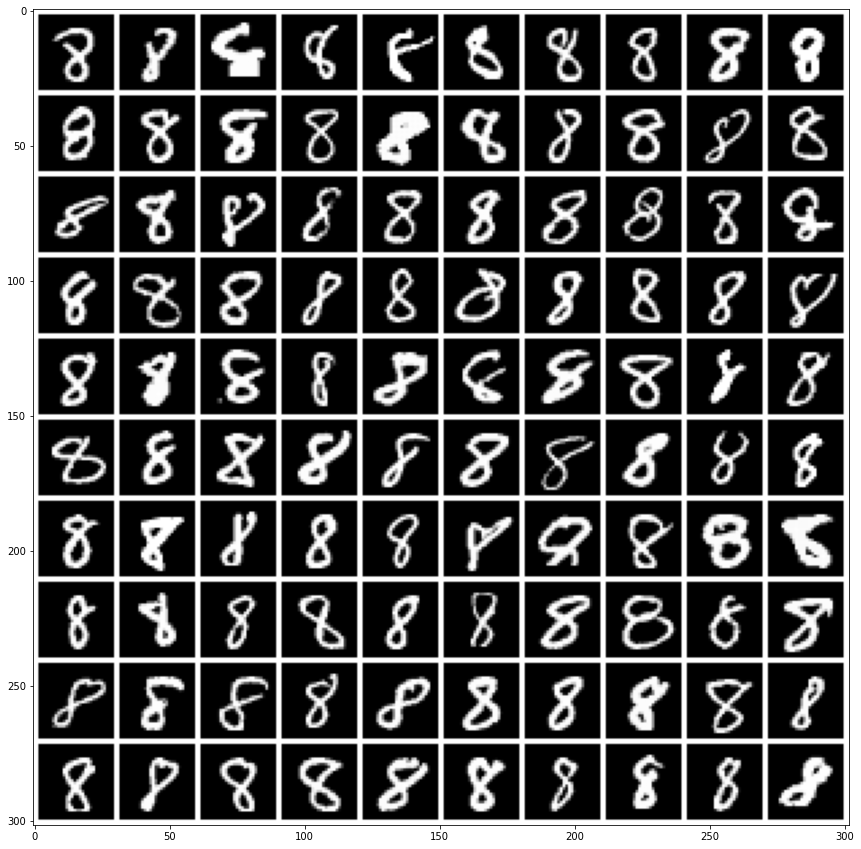

In [219]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

In [204]:
28*28

784

In [262]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [263]:
resnet18.modules

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

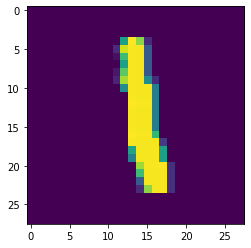

In [264]:
timg = train_dict[1][1]
plt.imshow(timg.squeeze())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


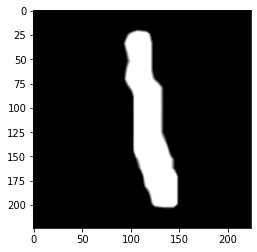

In [268]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.449, std=0.225),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

ptimg = preprocess(timg)
plt.imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


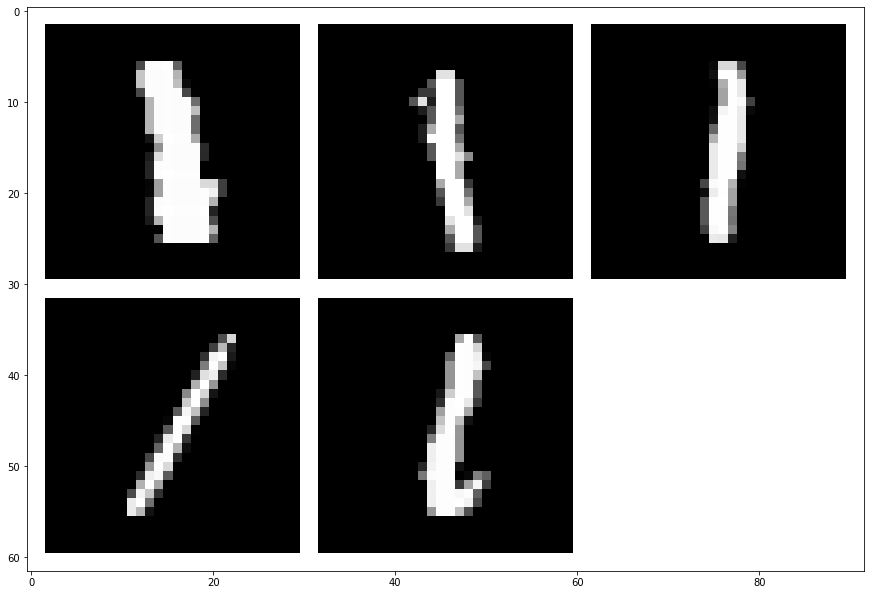

In [274]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=3, pad_value=20)
plt.imshow(np.transpose(grid, (1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


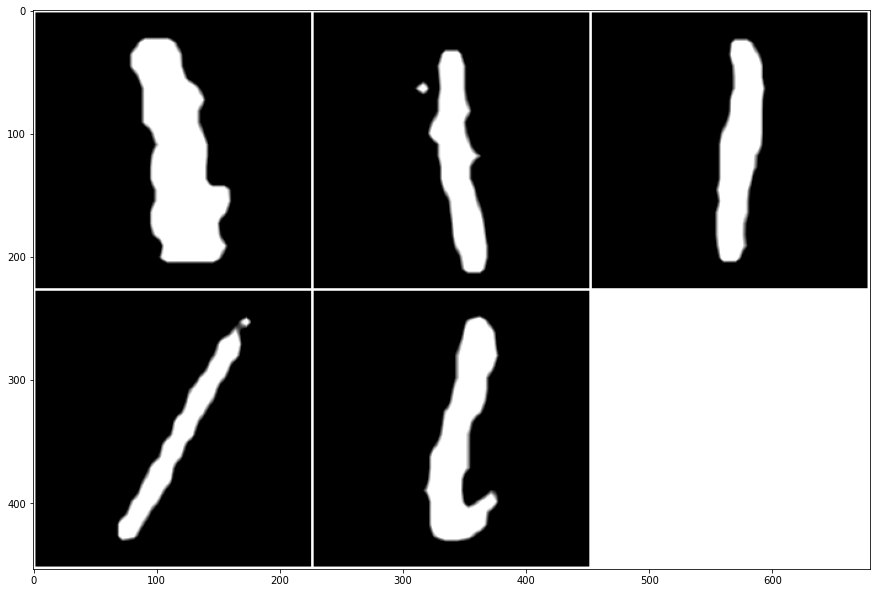

In [275]:
prand_imgs = preprocess(rand_imgs)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=3, pad_value=20)
plt.imshow(np.transpose(pgrid, (1,2,0)))

In [258]:
preds = resnet18(ptimg.unsqueeze(0))

In [261]:
preds

tensor([[-5.7961e-01,  1.9096e-01, -9.5929e-01,  1.1436e+00,  5.6881e-01,
          6.9387e-04, -5.5421e-01, -7.9364e-01,  3.8999e-01,  4.9545e-01,
         -4.7719e-02, -4.0619e-01,  4.1260e-01, -7.9662e-01,  1.7119e-01,
          1.1849e-01, -1.2790e-01, -1.0045e+00, -7.6475e-01, -3.1632e-01,
          4.8415e-01, -6.4857e-01, -1.2732e-01, -8.8602e-01,  1.9774e-01,
          7.5138e-01,  3.8384e-01, -3.7182e-02,  1.3520e+00,  1.4832e-01,
          1.3487e-01,  3.2415e-01, -4.1822e-01, -4.7448e-01, -8.8291e-01,
         -1.4948e-02,  4.6776e-02,  8.5656e-01, -2.1359e-01, -1.1307e-01,
         -6.0928e-01,  1.6701e-01,  3.9430e-01,  2.1137e-01,  2.8752e-01,
         -6.7702e-01, -1.0089e-01, -2.7594e-03, -3.1092e-01, -3.6883e-02,
         -4.2452e-02,  9.5288e-01,  3.7525e-01,  2.5016e-01, -2.9073e-01,
         -1.4581e-01, -1.0311e+00, -5.4044e-01,  7.7423e-01, -1.0194e+00,
         -4.8953e-01, -1.7120e-02,  1.8054e-01, -1.4571e-01, -6.3937e-01,
          3.6072e-01, -3.1676e-01,  4.